# A8 (25 Marks)
---
**Focus**: CUDA(E) - Performance Optimization

© Dr. Abdallah Mohamed


The aim of this lab is to implement the reduction algorithm we learned in class. You are required to write a full CUDA program to compute the **sum** of a 1D float array with 2^24 elements. In this assignment, you need to *implement* and *time* four versions of the kernel that will do the reduction:

- Version (1) uses the shared memory but has more divergence within the warps. This version is similar to the example on page 46 in the lecture notes “05G_CUDA_BestPractices”.
- Version (2) uses the shared memory and has less divergence. This is similar to the example on page 49 in the lecture notes.
- Version (3) is similar to version (1) but it does not use the shared memory (writes directly to the global memory).
- Version (4) is similar to version (2) but it does not use the shared memory.

In the host code (the main function), create a 1D array with 2^24 random float numbers from 0 to 255.
Then, launch each of the above four kernels, one at a time. The output should similar to one below:

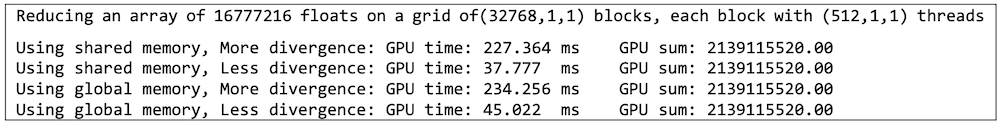

In addition, choose any of the four kernels and compare its execution time: (i) once using the ‘multiplication’ operator (*) to compute the ‘stride’, and (ii) another time using the ‘shift’ operator (<<). Report the difference in time. Note: ignore the error that Visual Studio displays for using __syncthreads(). Your code should still run with this error.

## Getting Started

1. Run the project setup cell (as you did in assignment A6 and A7). This pulls all the dependencies you will need for this project. Remember to rerun this cell anytime Google Colab allocates you a new instance.

2. Then, fill the reduction code cell below with your implementation.

## Marking Guide

- +16 for 4 kernels. The marks are distributed for each kernel as follows:
  - +1 for using global/shared memory
  - +1 for more/less divergence
  - +2 for correctness
- +8 for the host code distributed as follows:
  - +2 for timing the execution
  - +4 for kernel configuration and launch (+1 for each kernel)
  - +2 for other code (e.g., copying to/from GPU, freeing up the memory, etc).
- +1 for the difference between using * and <<
- +3 bonus for creating and using a macro to handle errors for CUDA function calls.

## What to Submit

- Copy and paste the output of the below Reduction Code cell into a reduction.cu file (this can just be a renamed text file).

## Notebook Setup

**Remember to re-run the following code block anytime you reconnect/connect/restart your Notebook!**

In [ ]:
# Download/Install/Enable NVCC4Jupyter
!pip install git+https://github.com/engasa/nvcc4jupyter.git
%load_ext nvcc_plugin
# check nvcc version + GPU Specs
!echo ""
!echo "------------------NVIDIA VERSION------------------------"
!nvcc --version
!echo ""
!echo "---------------------GPU SPECS------------------------"
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/engasa/nvcc4jupyter.git to /tmp/pip-req-build-3kcb3pxg
  Running command git clone -q https://github.com/engasa/nvcc4jupyter.git /tmp/pip-req-build-3kcb3pxg
The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin

------------------NVIDIA VERSION------------------------
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0

---------------------GPU SPECS------------------------
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Reduction Code

In [ ]:
%%cu

#include <stdio.h>

#include "device_launch_parameters.h"

#define NUM_THREADS_PER_BLOCK 512
#define N 100

#define CHK(call) { \
  cudaError_t err = call; \
  if (err != cudaSuccess) { \
    printf("Error%d: %s:%d\n",err,__FILE__,__LINE__); \
    printf(cudaGetErrorString(err)); \
    cudaDeviceReset(); \
    exit(1); \
  } \
}

__global__ void version_one(float* d_my_array, float* sum){
    __shared__ float partialSum[NUM_THREADS_PER_BLOCK];

    int i = threadIdx.x;

    partialSum[i] = d_my_array[blockIdx.x * blockDim.x + threadIdx.x];
    __syncthreads();

    for (int stride = 1; stride < blockDim.x; stride*=2) {
      if (i % (2 * stride) == 0) //all adjacent threads do the same thing
        partialSum[i] += partialSum[i + stride];
      __syncthreads();
    }

    if (i == 0) {
      sum[blockIdx.x] = partialSum[0];
    }
}

__global__ void version_two(float* d_my_array, float* sum){
    __shared__ float partialSum[NUM_THREADS_PER_BLOCK];

    int i = threadIdx.x;

    partialSum[i] = d_my_array[blockIdx.x * blockDim.x + threadIdx.x];

    __syncthreads();

    for (int stride = blockDim.x/2; stride >= 1; stride=stride/2) {
      if (i < stride) //all adjacent threads do the same thing
        partialSum[i] += partialSum[i + stride];
      __syncthreads();
    }

    if (i == 0) {
      sum[blockIdx.x] = partialSum[0];
    }
}

__global__ void version_two_bitwise(float* d_my_array, float* sum){
    __shared__ float partialSum[NUM_THREADS_PER_BLOCK];

    int i = threadIdx.x;

    partialSum[i] = d_my_array[blockIdx.x * blockDim.x + threadIdx.x];

    __syncthreads();

    for (int stride = blockDim.x >> 1; stride >= 1; stride>>=1) {
      if (i < stride) //all adjacent threads do the same thing
        partialSum[i] += partialSum[i + stride];
      __syncthreads();
    }

    if (i == 0) {
      sum[blockIdx.x] = partialSum[0];
    }
}

__global__ void version_three(float* d_my_array, float* sum){
    int i = blockIdx.x * blockDim.x + threadIdx.x;

    for (int stride = 1; stride < blockDim.x; stride*=2) {
      if (i % (2 * stride) == 0) //all adjacent threads do the same thing
        d_my_array[i] += d_my_array[i + stride];
      __syncthreads();
    }

    if (i == 0) {
      sum[blockIdx.x] = d_my_array[blockDim.x * blockIdx.x];
    }
}

__global__ void version_four(float* d_my_array, float* sum){
    int i = blockIdx.x * blockDim.x + threadIdx.x;

    for (int stride = blockDim.x/2; stride >= 1; stride=stride/2) {
      if (i < stride) //all adjacent threads do the same thing
        d_my_array[i] += d_my_array[i + stride];
      __syncthreads();
    }

    if (i == 0) {
      sum[blockIdx.x] = d_my_array[blockDim.x * blockIdx.x];
    }
}

void checkForGPU() {
    // This code attempts to check if a GPU has been allocated.
    // Colab notebooks without a GPU technically have access to NVCC and will
    // compile and execute CPU/Host code, however, GPU/Device code will silently
    // fail. To prevent such situations, this code will warn the user.
    int count;
    cudaGetDeviceCount(&count);
    if (count <= 0 || count > 100) {
        printf("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n");
        printf("->WARNING<-: NO GPU DETECTED ON THIS COLLABORATE INSTANCE.\n");
        printf("IF YOU ARE ATTEMPTING TO RUN GPU-BASED CUDA CODE, YOU SHOULD CHANGE THE RUNTIME TYPE!\n");
        printf("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n");
    }
}

float float_rand( float min, float max ) {
    float scale = rand() / (float) RAND_MAX; /* [0, 1.0] */
    return min + scale * ( max - min );      /* [min, max] */
}

int main() {

    // Your implementation goes here.
    // It's recommended that you keep the checkForGPU code since it serves
    // as a warning against silent CUDA failures on Colab.

    checkForGPU();

    // Configure blocks & threads
    int nblocks = (N-1) / NUM_THREADS_PER_BLOCK + 1;

    // Allocate space on Host
    float* my_array = (float*)malloc(N * sizeof(float));
    float* sum = (float*)malloc(NUM_THREADS_PER_BLOCK * sizeof(float));

    // Check for error
    if (my_array == NULL) {
        printf("Error malloc");
        exit(1);
    }

    // Initialize array
    for (int i = 0; i<N ; i++) {
        my_array[i] = float_rand(0, 255);
        // printf("%f\n", my_array[i]);
    }

    printf("Reducing an array of %d floats on a grid of (%d,1,1) blocks, each block with (%d,1,1) threads.\n", N, nblocks, NUM_THREADS_PER_BLOCK);

    /*************/
    /* Version 1 */
    /*************/

    // Allocate space on & copy data to Device
    float *d_my_array, *d_sum;
    CHK(cudaMalloc(&d_my_array, N * sizeof(float)));
    CHK(cudaMalloc(&d_sum, NUM_THREADS_PER_BLOCK * sizeof(float)));
    cudaMemcpy(d_my_array, my_array, N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_sum, sum, NUM_THREADS_PER_BLOCK * sizeof(float), cudaMemcpyHostToDevice);

    clock_t start_time = clock(), time_taken;
    version_one<<<nblocks,NUM_THREADS_PER_BLOCK>>>(d_my_array, d_sum);
    cudaMemcpy(sum, d_sum, NUM_THREADS_PER_BLOCK, cudaMemcpyDeviceToHost);
    cudaDeviceSynchronize();

    float version_one_sum = 0;
    for (int i = 0; i < nblocks; i++)
    {
        version_one_sum += sum[i];
    }
    cudaGetLastError();

    time_taken = ((float)(clock() - start_time) / CLOCKS_PER_SEC) * 1000; // in milisecond (ms)
    printf("Using shared memory, More divergence: GPU time: %.3f ms \t GPU sum: %.2f\n", time_taken, version_one_sum);

    cudaFree(my_array);
    cudaFree(d_sum);
    free(sum);

    /*************/
    /* Version 2 */
    /*************/

    // Allocate space on & copy data to Device
    CHK(cudaMalloc(&d_my_array, N * sizeof(float)));
    CHK(cudaMalloc(&d_sum, NUM_THREADS_PER_BLOCK * sizeof(float)));
    cudaMemcpy(d_my_array, my_array, N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_sum, sum, NUM_THREADS_PER_BLOCK * sizeof(float), cudaMemcpyHostToDevice);

    start_time = clock();
    version_two<<<nblocks,NUM_THREADS_PER_BLOCK>>>(d_my_array, d_sum);
    cudaMemcpy(sum, d_sum, NUM_THREADS_PER_BLOCK, cudaMemcpyDeviceToHost);
    cudaDeviceSynchronize();

    float version_two_sum = 0;
    for (int i = 0; i < nblocks; i++)
    {
        version_two_sum += sum[i];
    }
    cudaGetLastError();

    time_taken = ((float)(clock() - start_time) / CLOCKS_PER_SEC) * 1000; // in milisecond (ms)
    printf("Using shared memory, More divergence: GPU time: %.3f ms \t GPU sum: %.2f\n", time_taken, version_two_sum);

    double version_two_time = time_taken;

    cudaFree(my_array);
    cudaFree(d_sum);
    free(sum);

    /*************/
    /* Version 3 */
    /*************/

    // Allocate space on & copy data to Device
    CHK(cudaMalloc(&d_my_array, N * sizeof(float)));
    CHK(cudaMalloc(&d_sum, NUM_THREADS_PER_BLOCK * sizeof(float)));
    cudaMemcpy(d_my_array, my_array, N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_sum, sum, NUM_THREADS_PER_BLOCK * sizeof(float), cudaMemcpyHostToDevice);

    start_time = clock();
    version_three<<<nblocks,NUM_THREADS_PER_BLOCK>>>(d_my_array, d_sum);
    cudaMemcpy(sum, d_sum, NUM_THREADS_PER_BLOCK, cudaMemcpyDeviceToHost);
    cudaDeviceSynchronize();

    float version_three_sum = 0;
    for (int i = 0; i < nblocks; i++)
    {
        version_three_sum += sum[i];
    }
    cudaGetLastError();

    time_taken = ((float)(clock() - start_time) / CLOCKS_PER_SEC) * 1000; // in milisecond (ms)
    printf("Using shared memory, More divergence: GPU time: %.3f ms \t GPU sum: %.2f\n", time_taken, version_three_sum);

    cudaFree(my_array);
    cudaFree(d_sum);
    free(sum);

    /*************/
    /* Version 4 */
    /*************/

    // Allocate space on & copy data to Device
    CHK(cudaMalloc(&d_my_array, N * sizeof(float)));
    CHK(cudaMalloc(&d_sum, NUM_THREADS_PER_BLOCK * sizeof(float)));
    cudaMemcpy(d_my_array, my_array, N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_sum, sum, NUM_THREADS_PER_BLOCK * sizeof(float), cudaMemcpyHostToDevice);

    start_time = clock();
    version_four<<<nblocks,NUM_THREADS_PER_BLOCK>>>(d_my_array, d_sum);
    cudaMemcpy(sum, d_sum, NUM_THREADS_PER_BLOCK, cudaMemcpyDeviceToHost);
    cudaDeviceSynchronize();

    float version_four_sum = 0;
    for (int i = 0; i < nblocks; i++)
    {
        version_four_sum += sum[i];
    }
    cudaGetLastError();

    time_taken = ((float)(clock() - start_time) / CLOCKS_PER_SEC) * 1000; // in milisecond (ms)
    printf("Using shared memory, More divergence: GPU time: %.3f ms \t GPU sum: %.2f\n", time_taken, version_four_sum);

    cudaFree(my_array);
    cudaFree(d_sum);
    free(sum);

    /*********************/
    /* Version 2 Bitwise */
    /*********************/

    // Allocate space on & copy data to Device
    CHK(cudaMalloc(&d_my_array, N * sizeof(float)));
    CHK(cudaMalloc(&d_sum, NUM_THREADS_PER_BLOCK * sizeof(float)));
    cudaMemcpy(d_my_array, my_array, N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_sum, sum, NUM_THREADS_PER_BLOCK * sizeof(float), cudaMemcpyHostToDevice);

    start_time = clock();
    version_two_bitwise<<<nblocks,NUM_THREADS_PER_BLOCK>>>(d_my_array, d_sum);
    cudaMemcpy(sum, d_sum, NUM_THREADS_PER_BLOCK, cudaMemcpyDeviceToHost);
    cudaDeviceSynchronize();

    float version_two_bitwise_sum = 0;
    for (int i = 0; i < nblocks; i++)
    {
        version_two_bitwise_sum += sum[i];
    }
    cudaGetLastError();

    time_taken = ((float)(clock() - start_time) / CLOCKS_PER_SEC) * 1000; // in milisecond (ms)
    printf("Using shared memory, More divergence: GPU time: %.3f ms \t GPU sum: %.2f\n", time_taken, version_two_bitwise_sum);

    printf("Difference in time: %.3f", (time_taken - version_two_time));

    cudaFree(my_array);
    cudaFree(d_sum);
    free(sum);
    free(my_array);

    return 0;
}

/tmp/tmpmvvdrrjx/b0d8bd0d-a061-4c51-a088-cdec030ca8d2.cu(13): error: identifier "call" is undefined

/tmp/tmpmvvdrrjx/b0d8bd0d-a061-4c51-a088-cdec030ca8d2.cu(14): error: expected a declaration

/tmp/tmpmvvdrrjx/b0d8bd0d-a061-4c51-a088-cdec030ca8d2.cu(150): warning: parsing restarts here after previous syntax error

/tmp/tmpmvvdrrjx/b0d8bd0d-a061-4c51-a088-cdec030ca8d2.cu(151): error: this declaration has no storage class or type specifier

/tmp/tmpmvvdrrjx/b0d8bd0d-a061-4c51-a088-cdec030ca8d2.cu(151): error: declaration is incompatible with "void exit(int)"
/usr/include/stdlib.h(614): here

/tmp/tmpmvvdrrjx/b0d8bd0d-a061-4c51-a088-cdec030ca8d2.cu(152): error: expected a declaration

/tmp/tmpmvvdrrjx/b0d8bd0d-a061-4c51-a088-cdec030ca8d2.cu(160): warning: parsing restarts here after previous syntax error

/tmp/tmpmvvdrrjx/b0d8bd0d-a061-4c51-a088-cdec030ca8d2.cu(168): error: expected a declaration

/tmp/tmpmvvdrrjx/b0d8bd0d-a061-4c51-a088-cdec030ca8d2.cu(185): error: expected a declaratio

## Submission Instructions

For this assignment, you need to do the following:
1. Compress all your files (the source code) into one zip file and give it a name that
matches your ID (e.g., 1234567.zip).
2. Submit the zipped file to Canvas.

Note that you can resubmit an assignment, but the new submission overwrites the old submission and receives a new timestamp.